# Test Kaggle-Trained Models Locally
## Standalone Notebook for Testing Face Recognition Models

This notebook loads and tests the models trained on Kaggle without needing to run the full training pipeline.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## 1. Model Architecture Definitions
These must match the architecture used during training.

In [ ]:
# ============================================================
# BACKBONE DEFINITIONS
# ============================================================

def get_backbone(name, pretrained=False):
    """Get backbone network."""
    if name == 'resnet50':
        model = models.resnet50(weights=None)
        out_features = model.fc.in_features
        model.fc = nn.Identity()
    elif name == 'resnet101':
        model = models.resnet101(weights=None)
        out_features = model.fc.in_features
        model.fc = nn.Identity()
    elif name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=None)
        out_features = model.classifier[1].in_features
        model.classifier = nn.Identity()
    elif name == 'efficientnet_b3':
        model = models.efficientnet_b3(weights=None)
        out_features = model.classifier[1].in_features
        model.classifier = nn.Identity()
    elif name == 'densenet121':
        model = models.densenet121(weights=None)
        out_features = model.classifier.in_features
        model.classifier = nn.Identity()
    elif name == 'mobilenet_v3':
        model = models.mobilenet_v3_large(weights=None)
        out_features = model.classifier[0].in_features
        model.classifier = nn.Identity()
    elif name == 'convnext_tiny':
        model = models.convnext_tiny(weights=None)
        out_features = model.classifier[2].in_features
        # Keep LayerNorm2d and Flatten, only remove the Linear layer
        model.classifier = nn.Sequential(
            model.classifier[0],  # LayerNorm2d
            model.classifier[1],  # Flatten
        )
    else:
        raise ValueError(f"Unknown backbone: {name}")
    
    return model, out_features

In [3]:
# ============================================================
# CLASSIFIER HEAD DEFINITIONS
# ============================================================

class SimpleHead(nn.Module):
    """Simple linear classifier head."""
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class MLPHead(nn.Module):
    """Multi-layer perceptron head."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class DeepHead(nn.Module):
    """Deep MLP head with 2 hidden layers."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class AttentionHead(nn.Module):
    """Attention-based classifier head."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        return self.fc(x)

class CosFaceHead(nn.Module):
    """CosFace/ArcFace style head with normalized weights."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5, s=30.0, m=0.35):
        super().__init__()
        self.s = s
        self.m = m
        self.projection = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, hidden_dim))
        nn.init.xavier_uniform_(self.weight)
    
    def forward(self, x, labels=None):
        x = self.projection(x)
        x_norm = F.normalize(x, p=2, dim=1)
        w_norm = F.normalize(self.weight, p=2, dim=1)
        cosine = F.linear(x_norm, w_norm)
        output = self.s * cosine
        return output

def get_head(name, in_features, num_classes, dropout=0.5):
    """Get classifier head by name."""
    heads = {
        'simple': SimpleHead,
        'mlp': MLPHead,
        'deep': DeepHead,
        'attention': AttentionHead,
        'cosface': CosFaceHead
    }
    if name not in heads:
        raise ValueError(f"Unknown head: {name}")
    return heads[name](in_features, num_classes, dropout=dropout)

In [4]:
# ============================================================
# COMPLETE FACE CLASSIFIER MODEL
# ============================================================

class FaceClassifier(nn.Module):
    """Face identification model with configurable backbone and head."""
    
    def __init__(self, num_classes, backbone_name='resnet50', head_name='mlp', 
                 pretrained=False, dropout=0.5):
        super().__init__()
        self.backbone_name = backbone_name
        self.head_name = head_name
        self.num_classes = num_classes
        
        # Load backbone
        self.backbone, out_features = get_backbone(backbone_name, pretrained)
        
        # Create classifier head
        self.head = get_head(head_name, out_features, num_classes, dropout)
    
    def forward(self, x):
        features = self.backbone(x)
        if isinstance(features, tuple):
            features = features[0]
        return self.head(features)
    
    def predict(self, x):
        """Get predictions and probabilities."""
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
        return preds, probs

print("Model architecture defined!")

Model architecture defined!


## 2. Configuration

In [5]:
# Paths
MODELS_DIR = '../models/kaggle models'
DATA_DIR = '../data/lfw-deepfunneled/lfw-deepfunneled'

# Image settings
IMG_SIZE = 224

# List available models
available_models = [f.replace('.pt', '') for f in os.listdir(MODELS_DIR) if f.endswith('.pt')]
print(f"Available models ({len(available_models)}):")
for i, m in enumerate(sorted(available_models), 1):
    print(f"  {i:2d}. {m}")

Available models (20):
   1. densenet121_attention
   2. densenet121_cosface
   3. densenet121_deep
   4. densenet121_mlp
   5. densenet121_simple
   6. efficientnet_b0_attention
   7. efficientnet_b0_cosface
   8. efficientnet_b0_deep
   9. efficientnet_b0_mlp
  10. efficientnet_b0_simple
  11. mobilenet_v3_attention
  12. mobilenet_v3_cosface
  13. mobilenet_v3_deep
  14. mobilenet_v3_mlp
  15. mobilenet_v3_simple
  16. resnet50_attention
  17. resnet50_cosface
  18. resnet50_deep
  19. resnet50_mlp
  20. resnet50_simple


In [6]:
# Transform for inference
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def denormalize(tensor):
    """Convert normalized tensor back to displayable image."""
    img = tensor.cpu().permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    return np.clip(img, 0, 1)

## 3. Model Loading Functions

In [7]:
def load_model(model_name, models_dir=MODELS_DIR, device='cuda'):
    """Load a trained model from checkpoint."""
    checkpoint_path = os.path.join(models_dir, f"{model_name}.pt")
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Model not found: {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    # Extract info
    backbone = checkpoint['backbone']
    head = checkpoint['head']
    num_classes = checkpoint['num_classes']
    class_names = checkpoint['class_names']
    
    # Create and load model
    model = FaceClassifier(
        num_classes=num_classes,
        backbone_name=backbone,
        head_name=head,
        pretrained=False
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Get results if available
    results = checkpoint.get('results', {})
    
    print(f"Loaded: {model_name}")
    print(f"  Backbone: {backbone}, Head: {head}")
    print(f"  Classes: {num_classes}")
    if 'best_val_acc' in results:
        print(f"  Best Val Accuracy: {results['best_val_acc']:.2f}%")
    
    return model, class_names, results

# Test loading one model
test_model, class_names, _ = load_model(available_models[0], device=device)
print(f"\nClass names loaded: {len(class_names)} people")
print(f"First 5: {class_names[:5]}")
del test_model

Loaded: densenet121_attention
  Backbone: densenet121, Head: attention
  Classes: 100
  Best Val Accuracy: 79.34%

Class names loaded: 100 people
First 5: ['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder']


## 4. Load Test Images

In [8]:
def get_sample_images(data_dir, class_names, samples_per_class=2):
    """Get sample images from the dataset."""
    images = []
    labels = []
    paths = []
    
    for idx, person in enumerate(class_names[:20]):  # Limit to first 20 people
        person_dir = os.path.join(data_dir, person)
        if os.path.exists(person_dir):
            person_images = [f for f in os.listdir(person_dir) if f.endswith('.jpg')]
            for img_name in person_images[:samples_per_class]:
                img_path = os.path.join(person_dir, img_name)
                img = Image.open(img_path).convert('RGB')
                img_tensor = transform(img)
                images.append(img_tensor)
                labels.append(idx)
                paths.append(img_path)
    
    return torch.stack(images), labels, paths

# Load sample images
sample_images, sample_labels, sample_paths = get_sample_images(DATA_DIR, class_names)
print(f"Loaded {len(sample_images)} test images")

Loaded 40 test images


## 5. Test Single Model

In [9]:
# ============================================================
# SELECT MODEL TO TEST
# ============================================================
MODEL_TO_TEST = 'resnet50_mlp'  # Change this to test different models

model, class_names, results = load_model(MODEL_TO_TEST, device=device)

Loaded: resnet50_mlp
  Backbone: resnet50, Head: mlp
  Classes: 100
  Best Val Accuracy: 82.49%


In [10]:
# Run predictions
model.eval()
with torch.no_grad():
    images_gpu = sample_images.to(device)
    preds, probs = model.predict(images_gpu)

# Calculate accuracy
correct = sum(p.item() == l for p, l in zip(preds, sample_labels))
accuracy = 100.0 * correct / len(sample_labels)
print(f"\nTest Accuracy on {len(sample_labels)} samples: {accuracy:.2f}%")


Test Accuracy on 40 samples: 100.00%


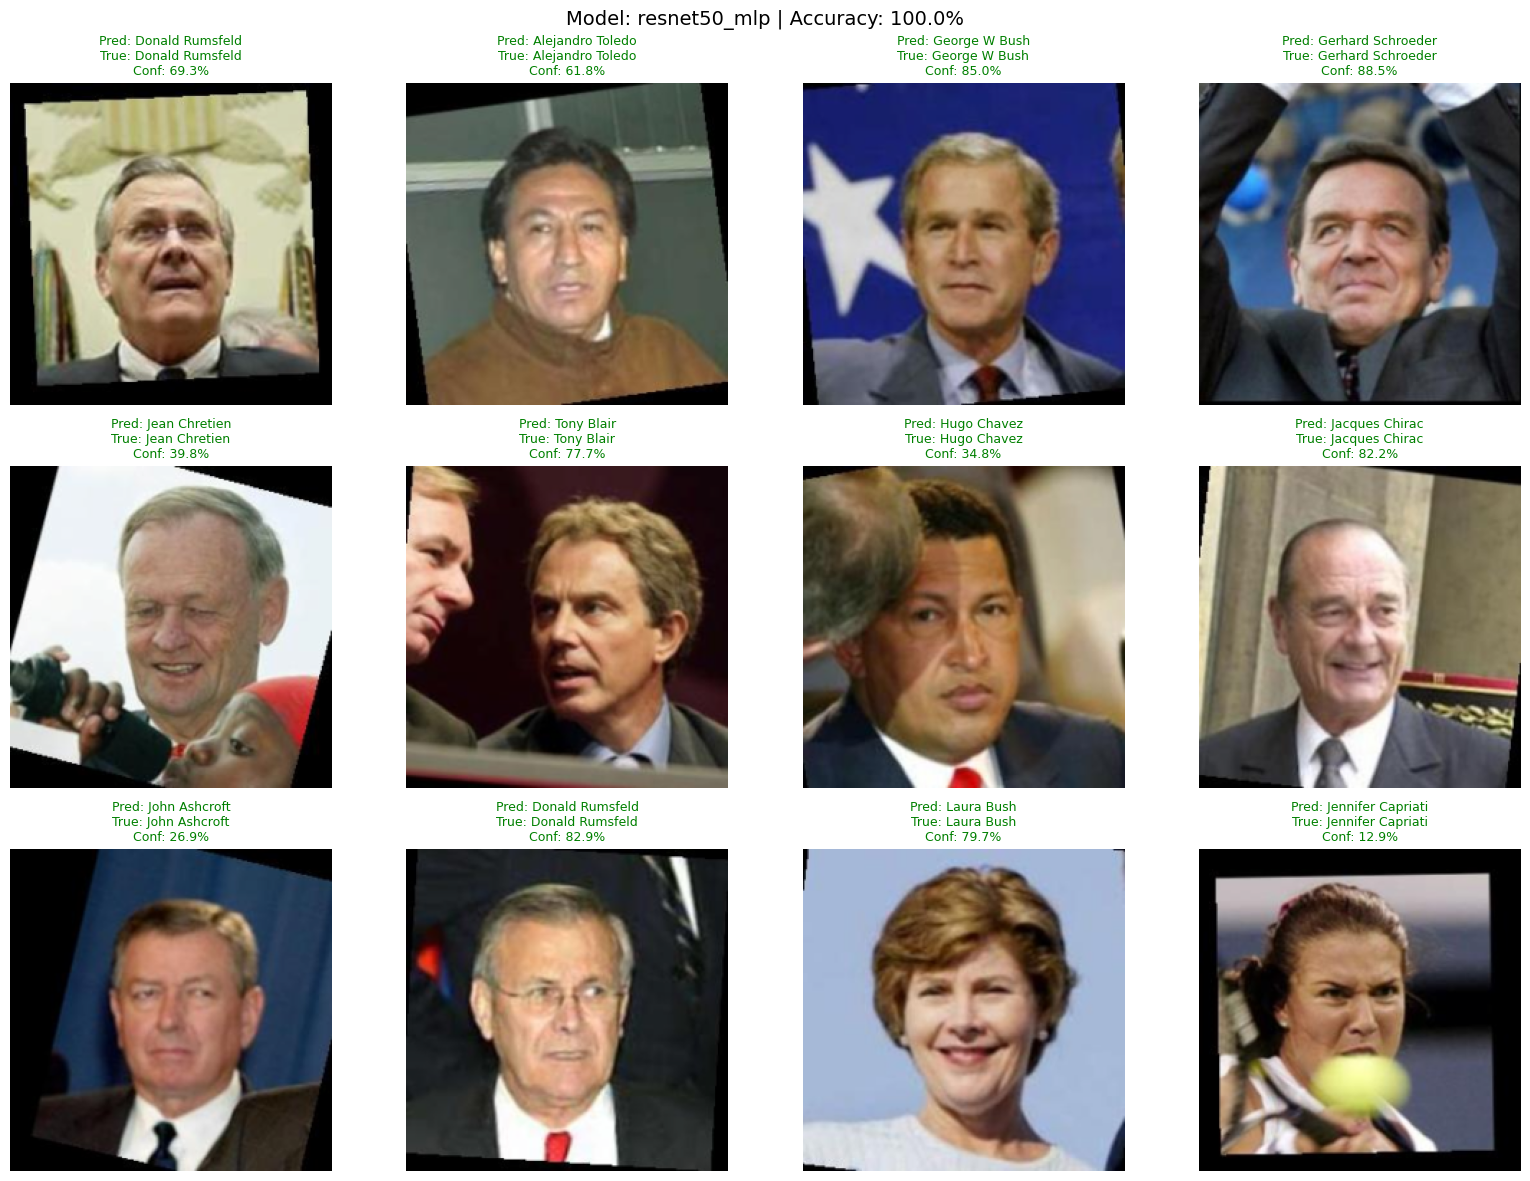

In [11]:
# Visualize predictions
n_show = 12
indices = np.random.choice(len(sample_images), min(n_show, len(sample_images)), replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
    if i >= len(indices):
        ax.axis('off')
        continue
    
    idx = indices[i]
    img = denormalize(sample_images[idx])
    
    pred_idx = preds[idx].item()
    true_idx = sample_labels[idx]
    conf = probs[idx, pred_idx].item()
    
    pred_name = class_names[pred_idx].replace('_', ' ')
    true_name = class_names[true_idx].replace('_', ' ')
    
    ax.imshow(img)
    color = 'green' if pred_idx == true_idx else 'red'
    ax.set_title(f'Pred: {pred_name}\nTrue: {true_name}\nConf: {conf:.1%}', 
                 color=color, fontsize=9)
    ax.axis('off')

plt.suptitle(f'Model: {MODEL_TO_TEST} | Accuracy: {accuracy:.1f}%', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Compare All Models

In [12]:
# Test all available models on the sample images
all_model_results = []

for model_name in sorted(available_models):
    try:
        model, _, res = load_model(model_name, device=device)
        
        model.eval()
        with torch.no_grad():
            images_gpu = sample_images.to(device)
            preds, probs = model.predict(images_gpu)
        
        correct = sum(p.item() == l for p, l in zip(preds, sample_labels))
        test_acc = 100.0 * correct / len(sample_labels)
        
        all_model_results.append({
            'model': model_name,
            'backbone': res.get('backbone', model_name.split('_')[0]),
            'head': res.get('head', '_'.join(model_name.split('_')[1:])),
            'kaggle_val_acc': res.get('best_val_acc', 0),
            'local_test_acc': test_acc
        })
        
        del model
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"  Error: {e}")

print(f"\nTested {len(all_model_results)} models")

Loaded: densenet121_attention
  Backbone: densenet121, Head: attention
  Classes: 100
  Best Val Accuracy: 79.34%
Loaded: densenet121_cosface
  Backbone: densenet121, Head: cosface
  Classes: 100
  Best Val Accuracy: 87.28%
Loaded: densenet121_deep
  Backbone: densenet121, Head: deep
  Classes: 100
  Best Val Accuracy: 57.46%
Loaded: densenet121_mlp
  Backbone: densenet121, Head: mlp
  Classes: 100
  Best Val Accuracy: 80.03%
Loaded: densenet121_simple
  Backbone: densenet121, Head: simple
  Classes: 100
  Best Val Accuracy: 76.33%
Loaded: efficientnet_b0_attention
  Backbone: efficientnet_b0, Head: attention
  Classes: 100
  Best Val Accuracy: 63.89%
Loaded: efficientnet_b0_cosface
  Backbone: efficientnet_b0, Head: cosface
  Classes: 100
  Best Val Accuracy: 72.50%
Loaded: efficientnet_b0_deep
  Backbone: efficientnet_b0, Head: deep
  Classes: 100
  Best Val Accuracy: 45.42%
Loaded: efficientnet_b0_mlp
  Backbone: efficientnet_b0, Head: mlp
  Classes: 100
  Best Val Accuracy: 63.61%


In [13]:
import pandas as pd

# Create results DataFrame
results_df = pd.DataFrame(all_model_results)
results_df = results_df.sort_values('kaggle_val_acc', ascending=False)

print("\nAll Models Comparison:")
print("="*80)
print(results_df.to_string(index=False))


All Models Comparison:
                    model        backbone      head  kaggle_val_acc  local_test_acc
          resnet50_simple        resnet50    simple       88.372093           100.0
      densenet121_cosface     densenet121   cosface       87.277702           100.0
         resnet50_cosface        resnet50   cosface       84.678523           100.0
             resnet50_mlp        resnet50       mlp       82.489740           100.0
       resnet50_attention        resnet50 attention       80.848153            97.5
          densenet121_mlp     densenet121       mlp       80.027360           100.0
    densenet121_attention     densenet121 attention       79.343365           100.0
       densenet121_simple     densenet121    simple       76.333789           100.0
  efficientnet_b0_cosface efficientnet_b0   cosface       72.503420            95.0
     mobilenet_v3_cosface    mobilenet_v3   cosface       70.861833           100.0
efficientnet_b0_attention efficientnet_b0 attention 

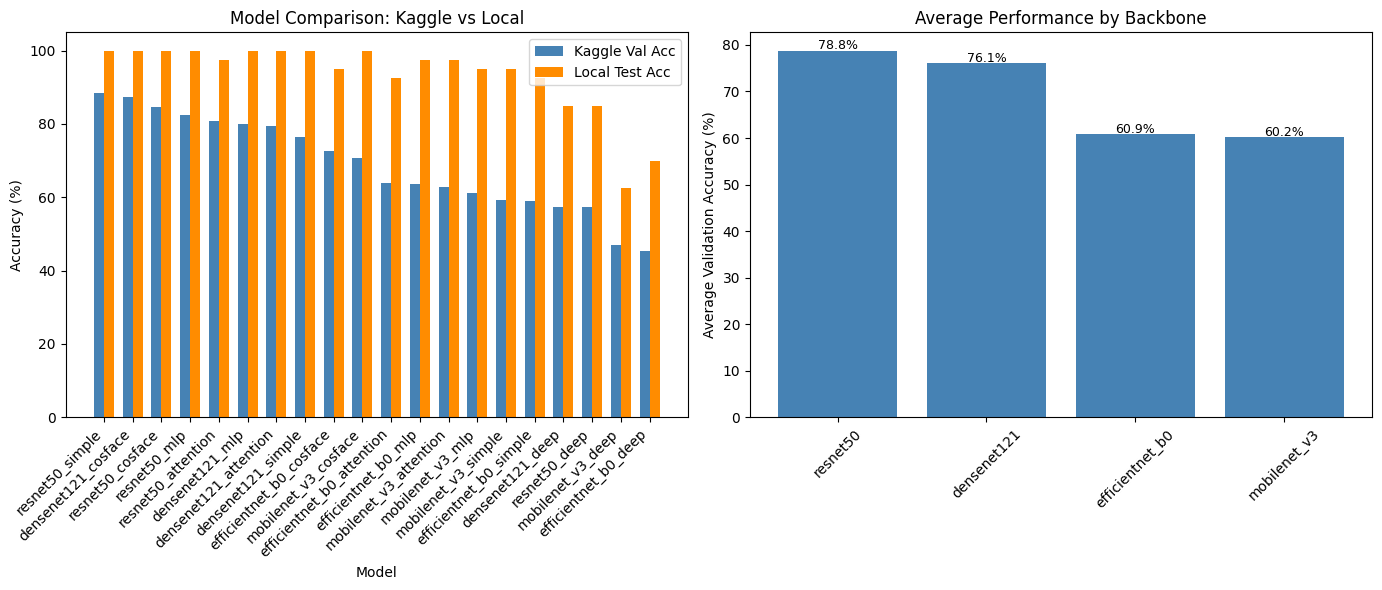

In [14]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart of accuracies
ax = axes[0]
x = range(len(results_df))
width = 0.35
ax.bar([i - width/2 for i in x], results_df['kaggle_val_acc'], width, label='Kaggle Val Acc', color='steelblue')
ax.bar([i + width/2 for i in x], results_df['local_test_acc'], width, label='Local Test Acc', color='darkorange')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Comparison: Kaggle vs Local')
ax.set_xticks(x)
ax.set_xticklabels(results_df['model'], rotation=45, ha='right')
ax.legend()

# Backbone comparison
ax = axes[1]
backbone_avg = results_df.groupby('backbone')['kaggle_val_acc'].mean().sort_values(ascending=False)
ax.bar(backbone_avg.index, backbone_avg.values, color='steelblue')
ax.set_ylabel('Average Validation Accuracy (%)')
ax.set_title('Average Performance by Backbone')
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(backbone_avg.values):
    ax.text(i, v + 0.3, f'{v:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [15]:
# Best model summary
best_model = results_df.iloc[0]
print("\n" + "="*60)
print("BEST MODEL")
print("="*60)
print(f"Model:              {best_model['model']}")
print(f"Backbone:           {best_model['backbone']}")
print(f"Head:               {best_model['head']}")
print(f"Kaggle Val Acc:     {best_model['kaggle_val_acc']:.2f}%")
print(f"Local Test Acc:     {best_model['local_test_acc']:.2f}%")
print("="*60)


BEST MODEL
Model:              resnet50_simple
Backbone:           resnet50
Head:               simple
Kaggle Val Acc:     88.37%
Local Test Acc:     100.00%


## 7. Test on Custom Image

In [16]:
def predict_image(image_path, model, class_names, device='cuda', top_k=5):
    """Predict the identity of a face in an image."""
    # Load and transform image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)
        probs = F.softmax(logits, dim=1)
    
    # Get top-k predictions
    top_probs, top_indices = probs[0].topk(top_k)
    
    results = []
    for prob, idx in zip(top_probs, top_indices):
        results.append({
            'name': class_names[idx.item()].replace('_', ' '),
            'confidence': prob.item()
        })
    
    return results, img

# Example usage (change path to test your own image)
# test_image_path = '../data/lfw-deepfunneled/lfw-deepfunneled/George_W_Bush/George_W_Bush_0001.jpg'
# if os.path.exists(test_image_path):
#     predictions, img = predict_image(test_image_path, model, class_names, device)
#     
#     plt.figure(figsize=(8, 6))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f"Top Predictions:")
#     
#     for i, pred in enumerate(predictions):
#         print(f"  {i+1}. {pred['name']}: {pred['confidence']:.2%}")
#     plt.show()

NameError: name 'model' is not defined

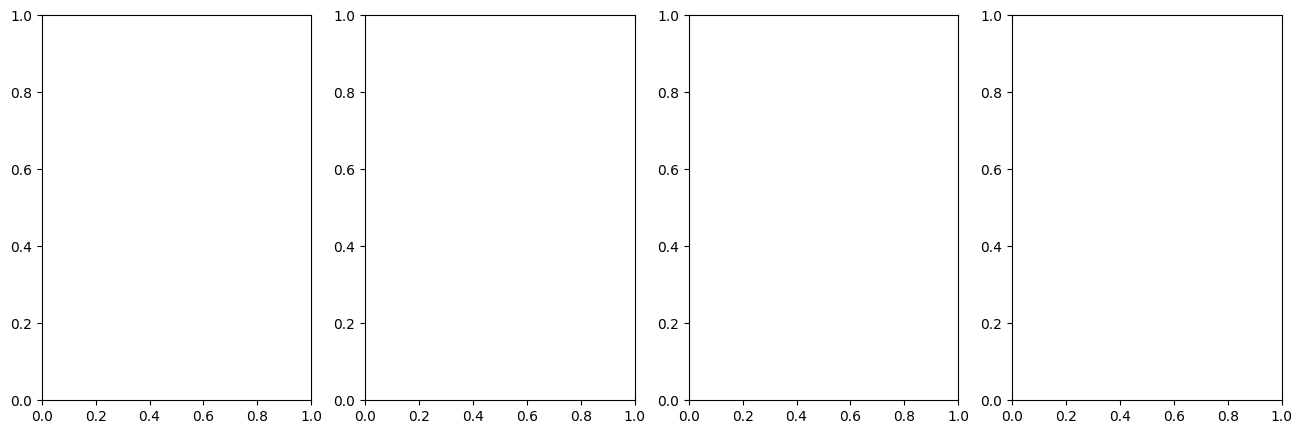

In [17]:
# Test on a specific person
test_person = 'George_W_Bush'
test_person_dir = os.path.join(DATA_DIR, test_person)

if os.path.exists(test_person_dir):
    test_images = [f for f in os.listdir(test_person_dir) if f.endswith('.jpg')][:4]
    
    fig, axes = plt.subplots(1, len(test_images), figsize=(4*len(test_images), 5))
    if len(test_images) == 1:
        axes = [axes]
    
    for ax, img_name in zip(axes, test_images):
        img_path = os.path.join(test_person_dir, img_name)
        predictions, img = predict_image(img_path, model, class_names, device)
        
        ax.imshow(img)
        ax.axis('off')
        
        title = f"Top 3 Predictions:\n"
        for pred in predictions[:3]:
            title += f"{pred['name']}: {pred['confidence']:.1%}\n"
        ax.set_title(title, fontsize=9)
    
    plt.suptitle(f'Testing: {test_person.replace("_", " ")}', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Person '{test_person}' not found in dataset")

## 8. Export Best Model for Video Inference

In [ ]:
# Find and export the best model for use with video_face_recognition.ipynb
best_model_name = results_df.iloc[0]['model']
best_model_checkpoint = os.path.join(MODELS_DIR, f"{best_model_name}.pt")

# Copy to the standard location
import shutil
output_path = '../models/checkpoints/best_kaggle_model.pt'
shutil.copy(best_model_checkpoint, output_path)
print(f"Best model copied to: {output_path}")

# Also update class_names.json
checkpoint = torch.load(best_model_checkpoint, map_location='cpu', weights_only=False)
class_names_path = '../models/checkpoints/class_names.json'
with open(class_names_path, 'w') as f:
    json.dump(checkpoint['class_names'], f, indent=2)
print(f"Class names saved to: {class_names_path}")

print(f"\nTo use with video_face_recognition.ipynb, update the checkpoint path to:")
print(f"  checkpoint_path = '{output_path}'")

## 9. Video Face Recognition Testing

Test the trained models on video files from the assets folder.

In [18]:
# Install facenet-pytorch for MTCNN face detection (run once)
# !pip install facenet-pytorch opencv-python

import cv2
from facenet_pytorch import MTCNN

# Initialize MTCNN face detector
mtcnn = MTCNN(
    keep_all=True,
    device=device,
    min_face_size=40,
    thresholds=[0.6, 0.7, 0.7]
)
print("MTCNN face detector initialized")

MTCNN face detector initialized


In [19]:
class VideoFaceRecognizer:
    """Video face recognition using MTCNN + trained classifier."""
    
    def __init__(self, model, class_names, mtcnn, device='cuda', conf_threshold=0.5):
        self.model = model
        self.class_names = class_names
        self.mtcnn = mtcnn
        self.device = device
        self.conf_threshold = conf_threshold
        self.model.eval()
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def process_frame(self, frame):
        """Process a single frame and return annotated frame."""
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Detect faces
        boxes, probs = self.mtcnn.detect(frame_rgb)
        
        if boxes is not None:
            for box, det_prob in zip(boxes, probs):
                if det_prob < 0.9:  # Skip low confidence detections
                    continue
                
                x1, y1, x2, y2 = map(int, box)
                
                # Ensure valid coordinates
                h, w = frame.shape[:2]
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)
                
                if x2 <= x1 or y2 <= y1:
                    continue
                
                # Extract and classify face
                face = frame_rgb[y1:y2, x1:x2]
                if face.size == 0:
                    continue
                
                face_tensor = self.transform(face).unsqueeze(0).to(self.device)
                
                with torch.no_grad():
                    logits = self.model(face_tensor)
                    probs_cls = F.softmax(logits, dim=1)
                    conf, pred = probs_cls.max(1)
                
                conf = conf.item()
                pred_idx = pred.item()
                
                if conf >= self.conf_threshold:
                    name = self.class_names[pred_idx].replace('_', ' ')
                    color = (0, 255, 0)  # Green
                else:
                    name = "Unknown"
                    color = (0, 0, 255)  # Red
                
                # Draw bounding box and label
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                label = f"{name}: {conf:.1%}"
                
                # Background for text
                (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(frame, (x1, y1 - th - 10), (x1 + tw, y1), color, -1)
                cv2.putText(frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        return frame
    
    def process_video(self, input_path, output_path=None, max_frames=None, show_progress=True):
        """Process entire video file."""
        cap = cv2.VideoCapture(input_path)
        
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {input_path}")
        
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if max_frames:
            total_frames = min(total_frames, max_frames)
        
        print(f"Video: {width}x{height} @ {fps}fps, {total_frames} frames")
        
        writer = None
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        frames_processed = 0
        from tqdm.auto import tqdm
        pbar = tqdm(total=total_frames, desc="Processing") if show_progress else None
        
        while True:
            ret, frame = cap.read()
            if not ret or (max_frames and frames_processed >= max_frames):
                break
            
            processed_frame = self.process_frame(frame)
            
            if writer:
                writer.write(processed_frame)
            
            frames_processed += 1
            if pbar:
                pbar.update(1)
        
        cap.release()
        if writer:
            writer.release()
        if pbar:
            pbar.close()
        
        print(f"Processed {frames_processed} frames")
        if output_path:
            print(f"Output saved to: {output_path}")
        
        return output_path

print("VideoFaceRecognizer class defined!")

VideoFaceRecognizer class defined!


In [37]:
# ============================================================
# SELECT MODEL FOR VIDEO TESTING
# ============================================================
VIDEO_MODEL = 'efficientnet_b0_cosface'  # Best performing model

# Load the model
video_model, video_class_names, _ = load_model(VIDEO_MODEL, device=device)

# Create recognizer
# NOTE: With 100 classes, confidence is naturally lower. Use 0.15-0.25 for better results.
recognizer = VideoFaceRecognizer(
    model=video_model,
    class_names=video_class_names,
    mtcnn=mtcnn,
    device=device,
    conf_threshold=0.20  # Lowered threshold - shows prediction if >= 20% confident
)
print(f"\nRecognizer ready with {len(video_class_names)} known people")

Loaded: efficientnet_b0_cosface
  Backbone: efficientnet_b0, Head: cosface
  Classes: 100
  Best Val Accuracy: 72.50%

Recognizer ready with 100 known people


In [38]:
# List available videos
ASSETS_DIR = '../assets'
videos = [f for f in os.listdir(ASSETS_DIR) if f.endswith(('.mp4', '.avi', '.mov'))]
print(f"Available videos in {ASSETS_DIR}:")
for i, v in enumerate(videos, 1):
    video_path = os.path.join(ASSETS_DIR, v)
    cap = cv2.VideoCapture(video_path)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    duration = frames / fps if fps > 0 else 0
    cap.release()
    print(f"  {i}. {v} ({duration:.1f}s, {frames} frames)")

Available videos in ../assets:
  1. test.mp4 (225.9s, 6551 frames)
  2. test2.mp4 (225.8s, 6549 frames)
  3. test3.mp4 (22.3s, 648 frames)
  4. test4.mp4 (5.0s, 121 frames)
  5. test6.mp4 (6.1s, 184 frames)


In [42]:
# ============================================================
# PROCESS A VIDEO
# ============================================================
# Change VIDEO_FILE to test different videos
VIDEO_FILE = 'test7.mp4'

input_video = os.path.join(ASSETS_DIR, VIDEO_FILE)
output_video = os.path.join('../outputs', f'recognized_{VIDEO_FILE}')

# Create outputs directory
os.makedirs('../outputs', exist_ok=True)

# Process video (set max_frames to limit for quick testing)
recognizer.process_video(
    input_path=input_video,
    output_path=output_video,
    max_frames=None,  # Set to e.g. 100 for quick test
    show_progress=True
)

Video: 640x480 @ 30fps, 7926 frames


Processing:   0%|          | 0/7926 [00:00<?, ?it/s]

Processed 7921 frames
Output saved to: ../outputs\recognized_test7.mp4


'../outputs\\recognized_test7.mp4'

In [ ]:
# Show sample frames from the processed video
def show_video_frames(video_path, num_frames=6):
    """Display sample frames from a video."""
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get evenly spaced frame indices
    indices = np.linspace(0, total - 1, num_frames, dtype=int)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, ax in enumerate(axes.flat):
        cap.set(cv2.CAP_PROP_POS_FRAMES, indices[i])
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            ax.imshow(frame_rgb)
            ax.set_title(f"Frame {indices[i]}", fontsize=10)
        ax.axis('off')
    
    cap.release()
    plt.suptitle(f"Sample Frames: {os.path.basename(video_path)}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Show frames from the output video
if os.path.exists(output_video):
    show_video_frames(output_video)
else:
    print(f"Output video not found: {output_video}")

In [ ]:
# ============================================================
# BATCH PROCESS ALL VIDEOS (Optional)
# ============================================================
# Uncomment to process all videos in assets folder

# for video_file in videos:
#     print(f"\n{'='*50}")
#     print(f"Processing: {video_file}")
#     input_path = os.path.join(ASSETS_DIR, video_file)
#     output_path = os.path.join('../outputs', f'recognized_{video_file}')
#     recognizer.process_video(input_path, output_path)
#     print(f"Saved to: {output_path}")

## 10. Compare All Models on Same Video

Test all 20 Kaggle models on the same video to see which performs best for video recognition.

In [28]:
# ============================================================
# TEST ALL 20 MODELS ON SAME VIDEO
# ============================================================
TEST_VIDEO = 'test6.mp4'
SAMPLE_FRAMES = 30  # Number of frames to sample for comparison

test_video_path = os.path.join(ASSETS_DIR, TEST_VIDEO)
cap = cv2.VideoCapture(test_video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Sample frames evenly
frame_indices = np.linspace(0, total_frames - 1, SAMPLE_FRAMES, dtype=int)

# Extract and detect faces in sample frames
print(f"Extracting {SAMPLE_FRAMES} frames from {TEST_VIDEO}...")
sample_frames = []
sample_faces = []  # List of (frame_idx, face_crop, box) tuples

for idx in frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if not ret:
        continue
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    boxes, probs = mtcnn.detect(frame_rgb)
    
    if boxes is not None:
        for box, prob in zip(boxes, probs):
            if prob < 0.9:
                continue
            x1, y1, x2, y2 = map(int, box)
            h, w = frame_rgb.shape[:2]
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            
            if x2 > x1 and y2 > y1:
                face = frame_rgb[y1:y2, x1:x2]
                if face.size > 0:
                    sample_faces.append((idx, face, box))
    
    sample_frames.append((idx, frame_rgb))

cap.release()
print(f"Detected {len(sample_faces)} faces across {len(sample_frames)} frames")

Extracting 30 frames from test6.mp4...
Detected 30 faces across 30 frames


In [29]:
# Test all models on the detected faces
from tqdm.auto import tqdm

video_model_results = []
face_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for model_name in tqdm(sorted(available_models), desc="Testing models"):
    try:
        test_model, test_class_names, res = load_model(model_name, device=device)
        test_model.eval()
        
        # Track predictions for this model
        all_preds = []
        all_confs = []
        high_conf_count = 0  # Confidence >= 50%
        
        for frame_idx, face, box in sample_faces:
            face_tensor = face_transform(face).unsqueeze(0).to(device)
            
            with torch.no_grad():
                logits = test_model(face_tensor)
                probs = F.softmax(logits, dim=1)
                conf, pred = probs.max(1)
            
            conf = conf.item()
            pred_idx = pred.item()
            pred_name = test_class_names[pred_idx]
            
            all_preds.append(pred_name)
            all_confs.append(conf)
            
            if conf >= 0.5:
                high_conf_count += 1
        
        # Calculate stats
        avg_conf = np.mean(all_confs) if all_confs else 0
        max_conf = np.max(all_confs) if all_confs else 0
        
        # Most common prediction
        from collections import Counter
        pred_counts = Counter(all_preds)
        most_common = pred_counts.most_common(3)
        
        video_model_results.append({
            'model': model_name,
            'backbone': res.get('backbone', ''),
            'head': res.get('head', ''),
            'kaggle_val_acc': res.get('best_val_acc', 0),
            'avg_confidence': avg_conf * 100,
            'max_confidence': max_conf * 100,
            'high_conf_pct': high_conf_count / len(sample_faces) * 100 if sample_faces else 0,
            'top_prediction': most_common[0][0].replace('_', ' ') if most_common else 'N/A',
            'top_pred_count': most_common[0][1] if most_common else 0,
        })
        
        del test_model
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"Error with {model_name}: {e}")

print(f"\nTested {len(video_model_results)} models on {len(sample_faces)} face detections")

Testing models:   0%|          | 0/20 [00:00<?, ?it/s]

Loaded: densenet121_attention
  Backbone: densenet121, Head: attention
  Classes: 100
  Best Val Accuracy: 79.34%
Loaded: densenet121_cosface
  Backbone: densenet121, Head: cosface
  Classes: 100
  Best Val Accuracy: 87.28%
Loaded: densenet121_deep
  Backbone: densenet121, Head: deep
  Classes: 100
  Best Val Accuracy: 57.46%
Loaded: densenet121_mlp
  Backbone: densenet121, Head: mlp
  Classes: 100
  Best Val Accuracy: 80.03%
Loaded: densenet121_simple
  Backbone: densenet121, Head: simple
  Classes: 100
  Best Val Accuracy: 76.33%
Loaded: efficientnet_b0_attention
  Backbone: efficientnet_b0, Head: attention
  Classes: 100
  Best Val Accuracy: 63.89%
Loaded: efficientnet_b0_cosface
  Backbone: efficientnet_b0, Head: cosface
  Classes: 100
  Best Val Accuracy: 72.50%
Loaded: efficientnet_b0_deep
  Backbone: efficientnet_b0, Head: deep
  Classes: 100
  Best Val Accuracy: 45.42%
Loaded: efficientnet_b0_mlp
  Backbone: efficientnet_b0, Head: mlp
  Classes: 100
  Best Val Accuracy: 63.61%


In [30]:
# Display results - sorted by average confidence (best for video recognition)
video_results_df = pd.DataFrame(video_model_results)
video_results_df = video_results_df.sort_values('avg_confidence', ascending=False)

print(f"\n{'='*100}")
print(f"VIDEO RECOGNITION COMPARISON: {TEST_VIDEO}")
print(f"{'='*100}")
print(f"Faces tested: {len(sample_faces)} | Frames sampled: {SAMPLE_FRAMES}")
print(f"{'='*100}\n")

# Display table
display_cols = ['model', 'kaggle_val_acc', 'avg_confidence', 'max_confidence', 'high_conf_pct', 'top_prediction', 'top_pred_count']
print(video_results_df[display_cols].to_string(index=False))

print(f"\n{'='*100}")
print("ANALYSIS:")
print(f"  - 'avg_confidence': Average confidence across all face detections")
print(f"  - 'max_confidence': Highest confidence prediction")
print(f"  - 'high_conf_pct': Percentage of predictions with confidence >= 50%")
print(f"{'='*100}")


VIDEO RECOGNITION COMPARISON: test6.mp4
Faces tested: 30 | Frames sampled: 30

                    model  kaggle_val_acc  avg_confidence  max_confidence  high_conf_pct top_prediction  top_pred_count
  efficientnet_b0_cosface       72.503420       43.670827       66.499418      33.333333  George W Bush              25
   mobilenet_v3_attention       62.927497       33.928992       44.966468       0.000000  George W Bush              30
      densenet121_cosface       87.277702       28.265322       48.492482       0.000000  George W Bush              22
       resnet50_attention       80.848153       26.677294       71.610385      10.000000  George W Bush              30
         resnet50_cosface       84.678523       23.564915       54.291344       6.666667   Colin Powell              12
          resnet50_simple       88.372093       22.757560       57.121909       3.333333  George W Bush              29
       densenet121_simple       76.333789       22.063249       33.632880       

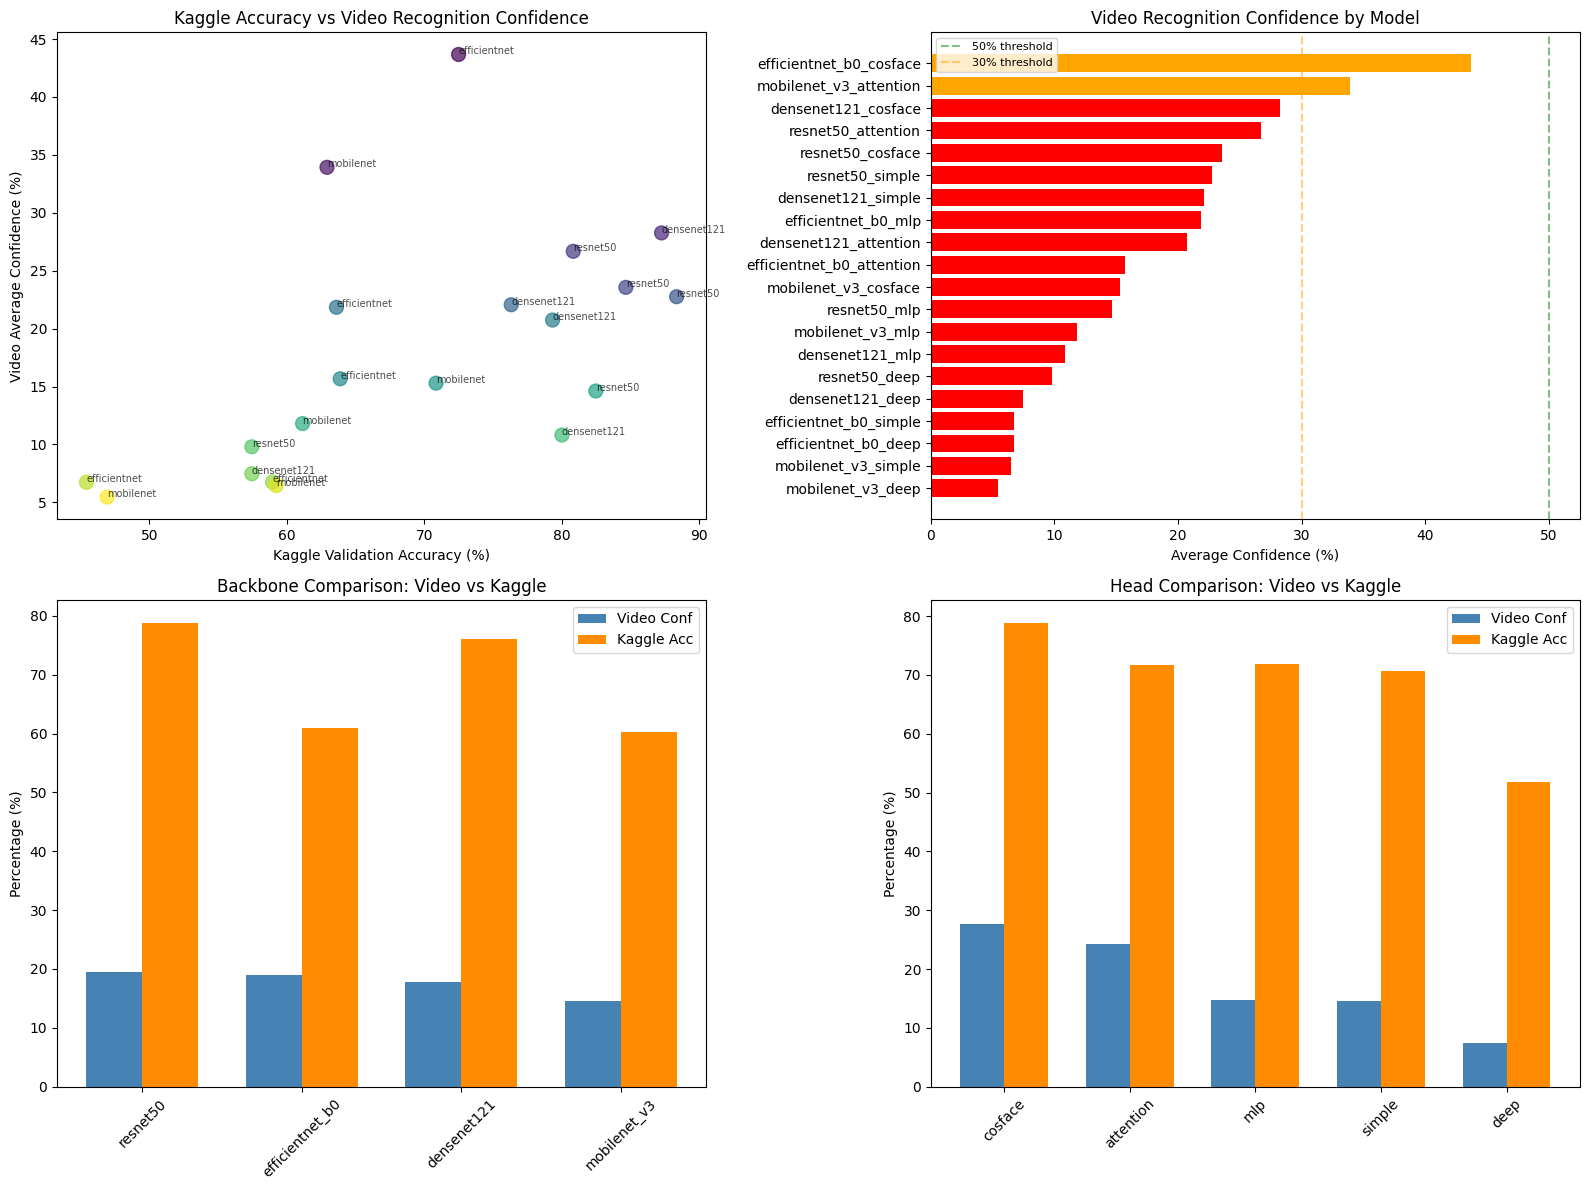


BEST MODEL FOR VIDEO RECOGNITION
Model:              efficientnet_b0_cosface
Avg Confidence:     43.7%
Max Confidence:     66.5%
High Conf %:        33.3%
Top Prediction:     George W Bush
Kaggle Val Acc:     72.5%


In [31]:
# Visualize video recognition performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Kaggle Val Acc vs Video Avg Confidence
ax = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(video_results_df)))
ax.scatter(video_results_df['kaggle_val_acc'], video_results_df['avg_confidence'], 
           c=colors, s=100, alpha=0.7)
for i, row in video_results_df.iterrows():
    ax.annotate(row['model'].split('_')[0], (row['kaggle_val_acc'], row['avg_confidence']), 
                fontsize=7, alpha=0.7)
ax.set_xlabel('Kaggle Validation Accuracy (%)')
ax.set_ylabel('Video Average Confidence (%)')
ax.set_title('Kaggle Accuracy vs Video Recognition Confidence')

# 2. Average confidence by model (bar chart)
ax = axes[0, 1]
sorted_df = video_results_df.sort_values('avg_confidence', ascending=True)
colors = ['green' if c >= 50 else 'orange' if c >= 30 else 'red' 
          for c in sorted_df['avg_confidence']]
ax.barh(sorted_df['model'], sorted_df['avg_confidence'], color=colors)
ax.axvline(50, color='green', linestyle='--', alpha=0.5, label='50% threshold')
ax.axvline(30, color='orange', linestyle='--', alpha=0.5, label='30% threshold')
ax.set_xlabel('Average Confidence (%)')
ax.set_title('Video Recognition Confidence by Model')
ax.legend(fontsize=8)

# 3. Backbone comparison for video
ax = axes[1, 0]
backbone_video = video_results_df.groupby('backbone').agg({
    'avg_confidence': 'mean',
    'kaggle_val_acc': 'mean'
}).sort_values('avg_confidence', ascending=False)
x = np.arange(len(backbone_video))
width = 0.35
ax.bar(x - width/2, backbone_video['avg_confidence'], width, label='Video Conf', color='steelblue')
ax.bar(x + width/2, backbone_video['kaggle_val_acc'], width, label='Kaggle Acc', color='darkorange')
ax.set_xticks(x)
ax.set_xticklabels(backbone_video.index, rotation=45)
ax.set_ylabel('Percentage (%)')
ax.set_title('Backbone Comparison: Video vs Kaggle')
ax.legend()

# 4. Head comparison for video
ax = axes[1, 1]
head_video = video_results_df.groupby('head').agg({
    'avg_confidence': 'mean',
    'kaggle_val_acc': 'mean'
}).sort_values('avg_confidence', ascending=False)
x = np.arange(len(head_video))
ax.bar(x - width/2, head_video['avg_confidence'], width, label='Video Conf', color='steelblue')
ax.bar(x + width/2, head_video['kaggle_val_acc'], width, label='Kaggle Acc', color='darkorange')
ax.set_xticks(x)
ax.set_xticklabels(head_video.index, rotation=45)
ax.set_ylabel('Percentage (%)')
ax.set_title('Head Comparison: Video vs Kaggle')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/video_model_comparison.png', dpi=150)
plt.show()

# Best model for video
best_video_model = video_results_df.iloc[0]
print(f"\n{'='*60}")
print(f"BEST MODEL FOR VIDEO RECOGNITION")
print(f"{'='*60}")
print(f"Model:              {best_video_model['model']}")
print(f"Avg Confidence:     {best_video_model['avg_confidence']:.1f}%")
print(f"Max Confidence:     {best_video_model['max_confidence']:.1f}%")
print(f"High Conf %:        {best_video_model['high_conf_pct']:.1f}%")
print(f"Top Prediction:     {best_video_model['top_prediction']}")
print(f"Kaggle Val Acc:     {best_video_model['kaggle_val_acc']:.1f}%")
print(f"{'='*60}")

In [32]:
# ============================================================
# COMPARE WITH ORIGINAL LOCAL MODEL (if available)
# ============================================================
original_model_path = '../models/checkpoints/face_recognition.pt'

if os.path.exists(original_model_path):
    print("Loading original local model for comparison...")
    orig_checkpoint = torch.load(original_model_path, map_location=device, weights_only=False)
    
    orig_model = FaceClassifier(
        num_classes=orig_checkpoint['num_classes'],
        backbone_name=orig_checkpoint.get('backbone', 'resnet50'),
        head_name=orig_checkpoint.get('head', 'mlp'),
        pretrained=False
    )
    orig_model.load_state_dict(orig_checkpoint['model_state_dict'])
    orig_model = orig_model.to(device)
    orig_model.eval()
    
    orig_class_names = orig_checkpoint['class_names']
    
    # Test on same faces
    orig_preds = []
    orig_confs = []
    
    for frame_idx, face, box in sample_faces:
        face_tensor = face_transform(face).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = orig_model(face_tensor)
            probs = F.softmax(logits, dim=1)
            conf, pred = probs.max(1)
        
        orig_confs.append(conf.item())
        orig_preds.append(orig_class_names[pred.item()])
    
    orig_avg_conf = np.mean(orig_confs) * 100
    orig_max_conf = np.max(orig_confs) * 100
    orig_high_conf = sum(c >= 0.5 for c in orig_confs) / len(orig_confs) * 100
    
    pred_counts = Counter(orig_preds)
    orig_top_pred = pred_counts.most_common(1)[0] if pred_counts else ('N/A', 0)
    
    print(f"\n{'='*60}")
    print("ORIGINAL LOCAL MODEL vs BEST KAGGLE MODEL")
    print(f"{'='*60}")
    print(f"{'Metric':<20} {'Original':<20} {'Best Kaggle':<20}")
    print(f"{'-'*60}")
    print(f"{'Avg Confidence':<20} {orig_avg_conf:<20.1f} {best_video_model['avg_confidence']:<20.1f}")
    print(f"{'Max Confidence':<20} {orig_max_conf:<20.1f} {best_video_model['max_confidence']:<20.1f}")
    print(f"{'High Conf %':<20} {orig_high_conf:<20.1f} {best_video_model['high_conf_pct']:<20.1f}")
    print(f"{'Top Prediction':<20} {orig_top_pred[0].replace('_', ' '):<20} {best_video_model['top_prediction']:<20}")
    print(f"{'='*60}")
    
    del orig_model
    torch.cuda.empty_cache()
else:
    print(f"Original model not found at {original_model_path}")

Loading original local model for comparison...


RuntimeError: Error(s) in loading state_dict for FaceClassifier:
	Missing key(s) in state_dict: "head.head.0.weight", "head.head.0.bias", "head.head.1.weight", "head.head.1.bias", "head.head.1.running_mean", "head.head.1.running_var", "head.head.4.weight", "head.head.4.bias". 
	Unexpected key(s) in state_dict: "classifier.1.weight", "classifier.1.bias", "classifier.4.weight", "classifier.4.bias". 